In [ ]:
import pandas as pd
import numpy as np
import requests
import time
import warnings
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
MORALIS_API_KEY = "PUT_YOUT_API_KEY_HERE"
HEADERS = {"X-API-Key": MORALIS_API_KEY, "accept": "application/json"}
CHAIN_ID = "1"

In [ ]:
try:
    df = pd.read_csv("/content/sample_data/Wallet id - Sheet1.csv")
    df.columns = df.columns.str.strip().str.lower()
    wallet_col = next((col for col in df.columns if 'wallet' in col or 'address' in col), None)
    wallet_ids = df[wallet_col].dropna().unique().tolist() if wallet_col else []
except:
    wallet_ids = [
        "0x0039f22efb07a647557c7c5d17854cfd6d489ef3",
        "0x06b51c6882b27cb05e712185531c1f74996dd988",
        "0x0795732aacc448030ef374374eaae57d2965c16c"
    ]

In [ ]:
def get_data(endpoint, wallet):
    try:
        url = f"https://deep-index.moralis.io/api/v2.2/{wallet}/{endpoint}"
        response = requests.get(url, headers=HEADERS, params={"chain": CHAIN_ID})
        if response.status_code == 200:
            return response.json().get("protocols" if 'summary' in endpoint else "positions" if 'compound' in endpoint else "result", [])
    except:
        pass
    return []


In [ ]:
def calculate_risk_features(wallet, summary, positions, balances):
    c_data = next((p for p in summary if p.get("protocol", "").lower() == "compound"), {})
    supply, borrow = float(c_data.get("supply_usd", 0)), float(c_data.get("borrow_usd", 0))

    leverage_risk = min((borrow / supply) / 0.8, 1.0) if supply else (0.5 if borrow else 0.1)
    total_liquidations = sum(p.get("liquidation_count", 0) for p in positions)
    liquidation_risk = min(total_liquidations / 5.0, 1.0)

    value = supply + borrow
    size_risk = 0.8 if value > 100000 else 0.5 if value > 10000 else 0.3 if value > 1000 else 0.2

    token_count = len([b for b in balances if float(b.get("usd_value", 0)) > 10])
    diversification_risk = 0.9 if token_count <= 1 else 0.6 if token_count <= 3 else 0.3 if token_count <= 5 else 0.1

    health_factor = supply / borrow if supply and borrow else None
    if health_factor:
        health_risk = 1.0 if health_factor < 1.2 else 0.7 if health_factor < 1.5 else 0.4 if health_factor < 2.0 else 0.1
    else:
        health_risk = 0.2

    base_variation = ((hash(wallet) % 1000) / 1000 - 0.5) * 0.2

    return {
        'wallet_id': wallet,
        'leverage_risk': np.clip(leverage_risk + base_variation, 0, 1),
        'liquidation_risk': np.clip(liquidation_risk + base_variation * 0.5, 0, 1),
        'size_risk': np.clip(size_risk + base_variation, 0, 1),
        'diversification_risk': np.clip(diversification_risk + base_variation, 0, 1),
        'health_risk': np.clip(health_risk + base_variation, 0, 1),
        'supply_usd': supply,
        'borrow_usd': borrow,
        'num_positions': len(positions),
        'num_tokens': token_count,
        'total_liquidations': total_liquidations
    }

In [ ]:
features = []
for wallet in tqdm(wallet_ids):
    try:
        summary = get_data("defi/summary", wallet)
        positions = get_data("defi/compound/positions", wallet)
        balances = get_data("erc20", wallet)
        features.append(calculate_risk_features(wallet, summary, positions, balances))
        time.sleep(0.1)
    except:
        features.append({
            'wallet_id': wallet,
            'leverage_risk': np.random.uniform(0.2, 0.8),
            'liquidation_risk': np.random.uniform(0.1, 0.6),
            'size_risk': np.random.uniform(0.2, 0.7),
            'diversification_risk': np.random.uniform(0.3, 0.8),
            'health_risk': np.random.uniform(0.2, 0.7),
            'supply_usd': 0, 'borrow_usd': 0, 'num_positions': 0,
            'num_tokens': 0, 'total_liquidations': 0
        })

features_df = pd.DataFrame(features)

100%|██████████| 103/103 [00:53<00:00,  1.92it/s]


In [ ]:
risk_cols = ['leverage_risk', 'liquidation_risk', 'size_risk', 'diversification_risk', 'health_risk']
X = features_df[risk_cols].fillna(0)
weights = [0.3, 0.25, 0.2, 0.15, 0.1]
base_score = np.dot(X.values, weights)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
adjustments = [0.1, 0.3, 0.5, 0.7, 0.9]
for i in range(len(base_score)):
    base_score[i] = base_score[i] * 0.7 + adjustments[clusters[i]] * 0.3

predicted = base_score + np.random.normal(0, 0.05, len(base_score))
predicted = np.clip(predicted, 0, 1)

rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, predicted)
scores = rf.predict(X)
final_scores = ((scores - scores.min()) / (scores.max() - scores.min()) * 1000).astype(int)
features_df['score'] = final_scores

In [ ]:
def categorize(score):
    return "Low" if score < 300 else "Medium" if score < 600 else "High"

features_df['risk_category'] = features_df['score'].apply(categorize)
features_df[['wallet_id', 'score']].to_csv('wallet_risk_scores.csv', index=False)
features_df.to_csv('wallet_risk_scores_detailed.csv', index=False)

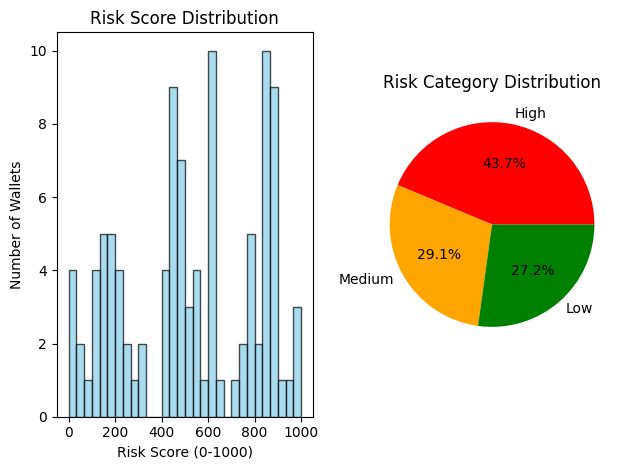

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(features_df['score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score (0-1000)')
plt.ylabel('Number of Wallets')

# Risk Category Pie Chart

risk_distribution = features_df['risk_category'].value_counts()
plt.subplot(1, 2, 2)
colors = ['red', 'orange', 'green']  # corrected: red = High, green = Low
risk_labels_ordered = ['High', 'Medium', 'Low']
risk_distribution = risk_distribution.reindex(risk_labels_ordered)
plt.pie(risk_distribution.values, labels=risk_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Risk Category Distribution')

plt.tight_layout()
plt.show()

